# Análise Titanic


Neste notebook iremos trabalhar com a base de dados dos passageiros do Titanic. O foco é avaliar os modelos para previsão se um passageiro sobreviverá ou não. 

## Etapa preliminar

A primeira etapa é carregar a base de dados

In [2]:
import pandas as pd

dados = pd.read_excel('http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.xls')

dados.head(3)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


A segunda etapa é verificar os dados faltantes

In [4]:
dados.info()

dados.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1309 non-null int64
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 143.2+ KB


pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

Podemos verificar que algumas colunas do banco de dados (as features) possuem valores faltantes. A coluna idade ('age') tem 263 casos com dados faltantes.

Vamos substituir os casos com dados faltantes com o valor da mediana da idade


In [5]:
## Inserir Idades faltantes com a Mediana
dados['age'].fillna(dados['age'].median(), inplace = True)

In [6]:
## Criar variável "familia" como a soma entre 'sibsp' e 'parch'
dados['familia'] = dados['sibsp'] + dados['parch'] 

## Gráficos descritivos

A seguir temos alguns gráficos descritivos das variáveis que serão utilizadas

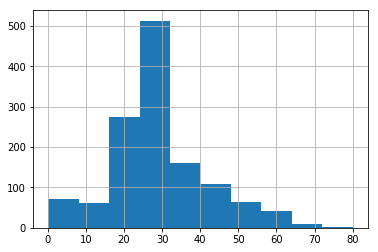

In [21]:
% matplotlib inline
dados['age'].hist()

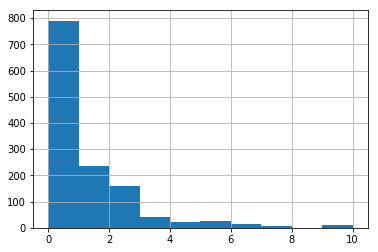

In [22]:
dados['familia'].hist()

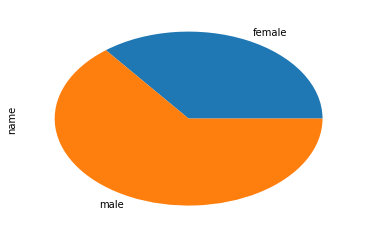

In [30]:
dados.groupby(['sex']).count()['name'].plot.pie()

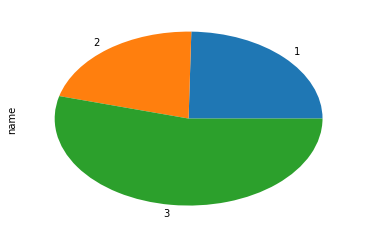

In [28]:
dados.groupby(['pclass']).count()['name'].plot.pie()

A próxima etapa é transformar as variáveis qualitativas em binárias (dummies)

In [7]:
## Transformar variáveis categóricas
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
labelencoder.fit_transform(dados['sex'])

dados_ajustados = pd.get_dummies(dados, columns=["pclass","sex"])

#Apagar as dummies que servirão de base
del dados_ajustados['sex_female']
del dados_ajustados['pclass_1']

### Rodar modelos

A partir de agora iremos rodar alguns modelos disponíveis no pacote Scikit Learn. Nesta primeira análise não iremos nos preocupar com o possível Overfitting dos modelos (ao não separar a base de dados entre treino e teste).


In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Tabela com resultados finais
resultados_acuracia = pd.DataFrame(columns = ['modelo', 'acuracia'])

### Regressão Logística

In [9]:
#################################################
##
## Rodar Regressão logística usando Scikit Learn
##
#################################################

from sklearn.linear_model import LogisticRegression

# Modelo
regressao_logistica = LogisticRegression(fit_intercept = True)
regressao_logistica.fit(dados_ajustados[['pclass_2','pclass_3','age','sex_male','familia']],dados_ajustados['survived'])
regressao_logistica.intercept_[0]
regressao_logistica.coef_[0]

# Resultados
previsto = regressao_logistica.predict(dados_ajustados[['pclass_2','pclass_3','age','sex_male','familia']])

acuracia = accuracy_score(dados_ajustados['survived'],previsto)
confusion_matrix(dados_ajustados['survived'],previsto)

tn, fp, fn, tp = confusion_matrix(dados_ajustados['survived'],previsto).ravel()

# Adicionar à tabela de resultados finais
resultados_acuracia = resultados_acuracia.append({'modelo':'lr_sklearn', 'acuracia':acuracia}, ignore_index = True)


#################################################
##
## Rodar Regressão logística usando Statsmodels
##
#################################################

### Regressão logistica Statsmodels
import statsmodels.api as sm
import statsmodels.discrete.discrete_model as dm

# Adicionar constante
cte_dados = sm.add_constant(dados_ajustados[['pclass_2','pclass_3','age','sex_male','familia']])

# Modelo
logit = dm.Logit(dados_ajustados['survived'], cte_dados)
logit.fit().params
logit.fit().summary()

# Resultados
previsto = logit.fit().predict(cte_dados)
previsto = pd.DataFrame([1 if item>=.5 else 0 for item in previsto])

acuracia = accuracy_score(dados_ajustados['survived'],previsto)
confusion_matrix(dados_ajustados['survived'],previsto)

tn, fp, fn, tp = confusion_matrix(dados_ajustados['survived'],previsto).ravel()

# Adicionar à tabela de resultados finais
resultados_acuracia = resultados_acuracia.append({'modelo':'lr_stats', 'acuracia':acuracia}, ignore_index = True)


/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Optimization terminated successfully.
         Current function value: 0.464663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464663
         Iterations 6


### KNN (K Nearest Neighbors)

In [10]:
from sklearn.neighbors import KNeighborsClassifier

# Modelo
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(dados_ajustados[['pclass_2','pclass_3','age','sex_male','familia']],dados_ajustados['survived'])

# Resultados
previsto = knn.predict(dados_ajustados[['pclass_2','pclass_3','age','sex_male','familia']])

acuracia = accuracy_score(dados_ajustados['survived'],previsto)
confusion_matrix(dados_ajustados['survived'],previsto)

# Adicionar à tabela de resultados finais
resultados_acuracia = resultados_acuracia.append({'modelo':'knn', 'acuracia':acuracia}, ignore_index = True)


### Naive Bayes

In [11]:
from sklearn.naive_bayes import GaussianNB

# Modelo
gaussian_nb = GaussianNB()
gaussian_nb.fit(dados_ajustados[['pclass_2','pclass_3','age','sex_male','familia']],dados_ajustados['survived'])

# Resultados
previsto = gaussian_nb.predict(dados_ajustados[['pclass_2','pclass_3','age','sex_male','familia']])

acuracia = accuracy_score(dados_ajustados['survived'],previsto)
confusion_matrix(dados_ajustados['survived'],previsto)

# Adicionar à tabela de resultados finais
resultados_acuracia = resultados_acuracia.append({'modelo':'naive_bayes', 'acuracia':acuracia}, ignore_index = True)


### Análise Discriminante

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Modelo
discriminante = LinearDiscriminantAnalysis()
discriminante.fit(dados_ajustados[['pclass_2','pclass_3','age','sex_male','familia']],dados_ajustados['survived'])

# Resultados
previsto = discriminante.predict(dados_ajustados[['pclass_2','pclass_3','age','sex_male','familia']])

acuracia = accuracy_score(dados_ajustados['survived'],previsto)
confusion_matrix(dados_ajustados['survived'],previsto)

# Adicionar à tabela de resultados finais
resultados_acuracia = resultados_acuracia.append({'modelo':'lda', 'acuracia':acuracia}, ignore_index = True)


### SVM (Support Vector Machine)

In [18]:
from sklearn import svm

# Modelo
modelo_svm = svm.SVC(gamma=0.1, C=1.0)
modelo_svm.fit(dados_ajustados[['pclass_2','pclass_3','age','sex_male','familia']],dados_ajustados['survived'])

# Resultados
previsto = modelo_svm.predict(dados_ajustados[['pclass_2','pclass_3','age','sex_male','familia']])

acuracia = accuracy_score(dados_ajustados['survived'],previsto)
confusion_matrix(dados_ajustados['survived'],previsto)

# Adicionar à tabela de resultados finais
resultados_acuracia = resultados_acuracia.append({'modelo':'svm', 'acuracia':acuracia}, ignore_index = True)


### Árvore de Decisão

In [14]:
from sklearn.tree import DecisionTreeClassifier

# Modelo
arvore = DecisionTreeClassifier()
arvore.fit(dados_ajustados[['pclass_2','pclass_3','age','sex_male','familia']],dados_ajustados['survived'])

# Resultados
previsto = arvore.predict(dados_ajustados[['pclass_2','pclass_3','age','sex_male','familia']])

acuracia = accuracy_score(dados_ajustados['survived'],previsto)
confusion_matrix(dados_ajustados['survived'],previsto)

# Adicionar à tabela de resultados finais
resultados_acuracia = resultados_acuracia.append({'modelo':'tree', 'acuracia':acuracia}, ignore_index = True)


In [19]:
resultados_acuracia

,modelo,acuracia
0,lr_sklearn,0.789152
1,lr_stats,0.783040
2,knn,0.838044
3,naive_bayes,0.799847
4,lda,0.788388
5,tree,0.880825
6,svm,0.636364
7,svm,0.813598
